# Chess Data Analysis with Python

In this notebook we will:

1.Look at general trends in games from the archive

2.Review top parings and players.

3.Use the chess python package to review a game

4.Use the stockfish engine to analyze a game position

# 1.General Chess Trends

In [44]:
%pip install chess -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import chess.pgn
import chess

pd.set_option('display.max_columns',500)
sns.set_palette("colorblind")
pal = sns.color_palette()
plt.style.use('ggplot')

In [46]:
df = pd.read_parquet('E:/EDA/twic_master.parquet')

In [47]:
df.head()

,twic_number,White,Black,Date,EventDate,Event,Result,mainline_moves,Site,Online,Round,ECO,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo,Variation,WhiteTitle,BlackTitle,WhiteTeam,BlackTeam,EventType,FEN,SetUp,Variant,Board,PlyCount,EventCategory
0,1260,"Tukhaev,A","Carlsen,M",2018-12-26,2018.12.26,World Rapid 2018,1-0,1. e4 c5 2. Nf3 Nc6 3. d4 cxd4 4. Nxd4 Nf6 5. ...,St Petersburg RUS,False,1.1,B33,Sicilian,14109476,1503014,2527,2835,"Pelikan, Chelyabinsk variation",GM,GM,None,None,None,None,None,None,None,None,None
1,1260,"Nakamura,Hi","Teske,H",2018-12-26,2018.12.26,World Rapid 2018,1-0,1. Nf3 Nf6 2. g3 d5 3. Bg2 g6 4. c4 dxc4 5. Na...,St Petersburg RUS,False,1.2,A05,Reti opening,2016192,4611500,2746,2483,None,GM,GM,None,None,None,None,None,None,None,None,None
2,1260,"Tari,A","Artemiev,V",2018-12-26,2018.12.26,World Rapid 2018,0-1,1. e4 c5 2. Nf3 d6 3. Bb5+ Bd7 4. c4 Nc6 5. d4...,St Petersburg RUS,False,1.3,B52,Sicilian,1510045,24101605,2620,2709,"Canal-Sokolsky attack, 3...Bd7",GM,GM,None,None,None,None,None,None,None,None,None
3,1260,"Fedoseev,Vl3","Tregubov,P",2018-12-26,2018.12.26,World Rapid 2018,1/2-1/2,1. e4 e5 2. Nf3 Nf6 3. Nxe5 d6 4. Nd3 Nxe4 5. ...,St Petersburg RUS,False,1.4,C42,Petrov's defence,24130737,4115341,2719,2592,None,GM,GM,None,None,None,None,None,None,None,None,None
4,1260,"Hovhannisyan,R","Aronian,L",2018-12-26,2018.12.26,World Rapid 2018,1-0,1. e4 g6 2. d4 Bg7 3. Nc3 c6 4. Nf3 d6 5. h3 N...,St Petersburg RUS,False,1.5,B06,Robatsch defence,13302507,13300474,2637,2765,"two knights, Suttles variation",GM,GM,None,None,None,None,None,None,None,None,None


# Who are the most frequent players in the Archive

In [48]:
pd.concat([df['White'], df['Black']]).value_counts().head()

Nakamura,Hi     4688
Sarana,A        3537
Andreikin,D     3103
Kamsky,G        3091
Fedoseev,Vl3    3031
Name: count, dtype: int64

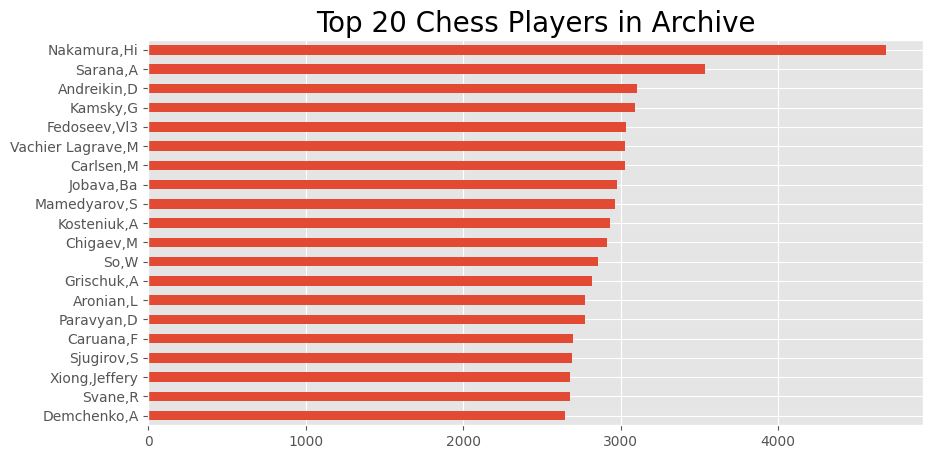

In [49]:
fig,ax= plt.subplots(figsize=(10,5))
pd.concat([df['White'],df['Black']]).value_counts(ascending=True).tail(20).plot(kind='barh', ax=ax)
ax.set_title('Top 20 Chess Players in Archive', fontsize = 20)
plt.show()

# What were the top opning each year?


In [50]:
df['Year'] = df['Date'].dt.year
df = df.query('2023 > Year >2012')

In [51]:
df['Year'].unique()

array([2018, 2017, 2015, 2014, 2020, 2016, 2013, 2022, 2021, 2019],
      dtype=int32)

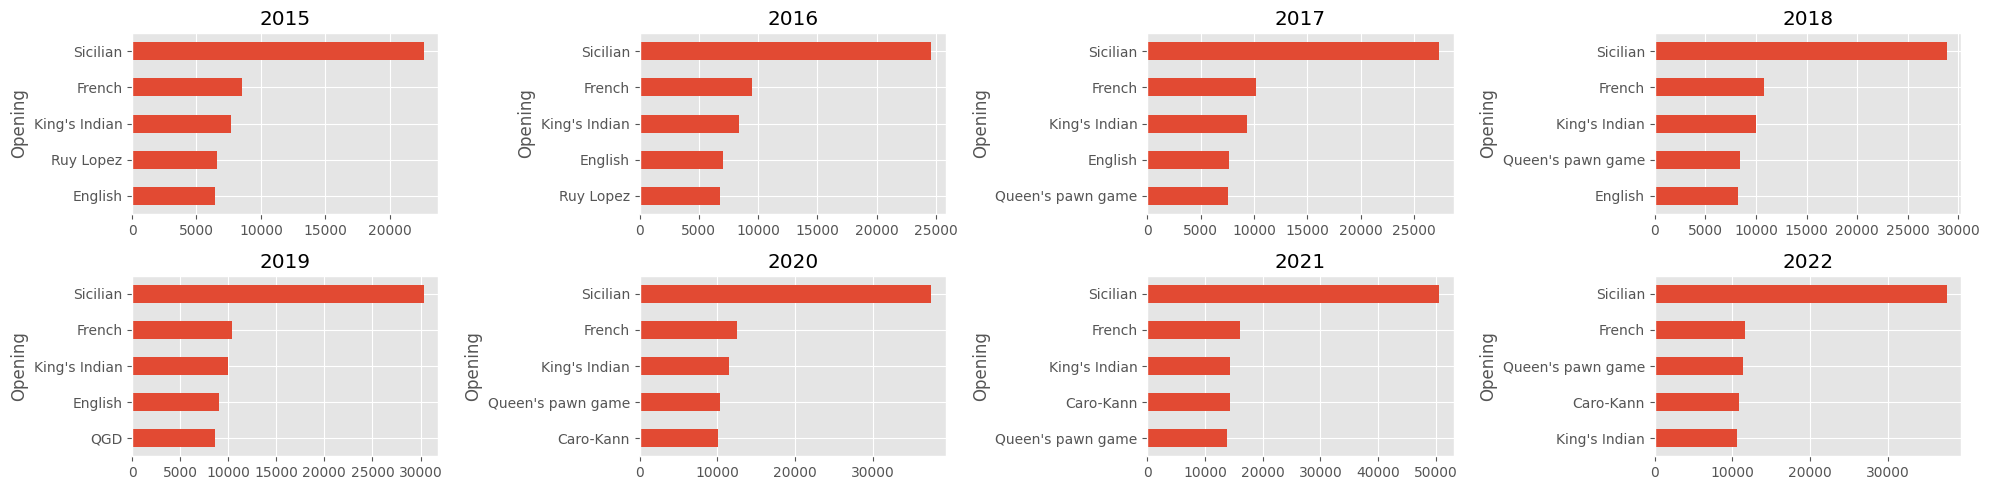

In [52]:
fig, axs = plt.subplots(2,4 , figsize=(20,5))
axs = axs.flatten()
for i, myyear in enumerate (range(2015,2023)):
    df.query("Year == @myyear")["Opening"].value_counts(ascending=True).tail(5).plot(kind = 'barh',title = myyear,ax=axs[i])
plt.tight_layout()
plt.show()
    

# What % of Games in the Archive were Online over time?


In [53]:
df['Week'] = df['Date'].dt.isocalendar().week

In [54]:
df = df.sort_values('Date')

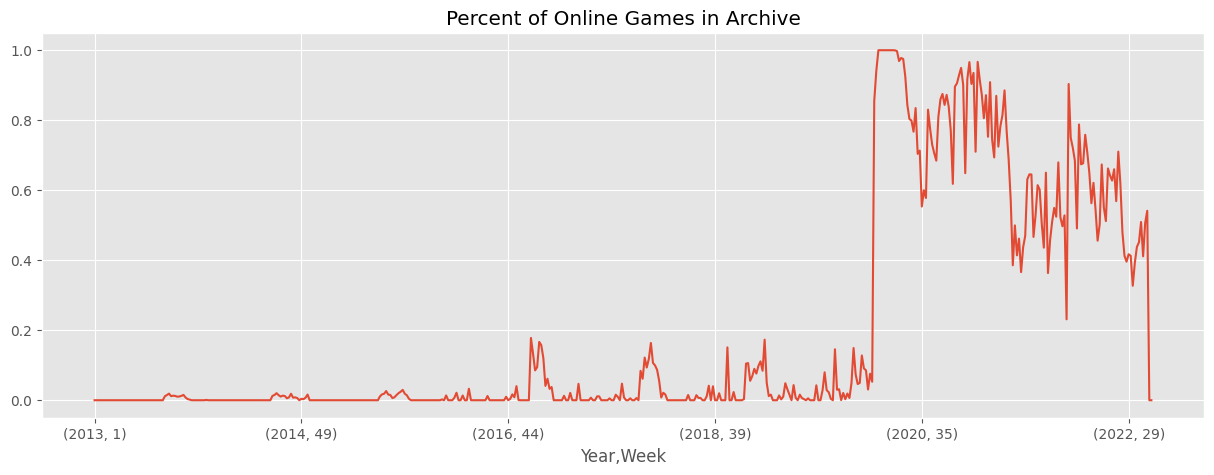

In [55]:
fig, axs = plt.subplots(figsize= (15,5))
df.groupby(['Year', 'Week'])['Online'].mean().plot(title='Percent of Online Games in Archive')
plt.show()

# Use chess package to review Game
-Can we find the "biggest upset" game

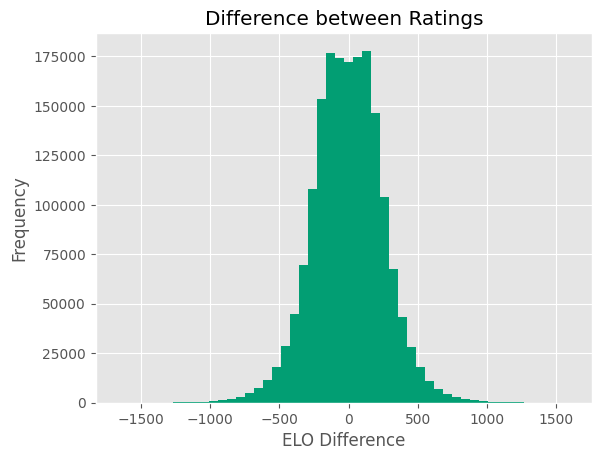

In [56]:
df_= (
    df.dropna(subset=["BlackElo","WhiteElo"])
.astype({"BlackElo":"int","WhiteElo": "int"})
.copy()
)
df_["Elo_diff"] = df_['BlackElo'] -df_["WhiteElo"]
df_=df_.drop(1662955).copy()
ax = df_["Elo_diff"].plot(kind="hist", bins=50,title="Difference between Ratings",color=pal[2])
ax.set_xlabel("ELO Difference")
plt.show()

In [57]:
df_["WhiteIsRatedHigher"] = df_["WhiteElo"] > df_["BlackElo"]

In [58]:
df_.shape

(1768599, 33)

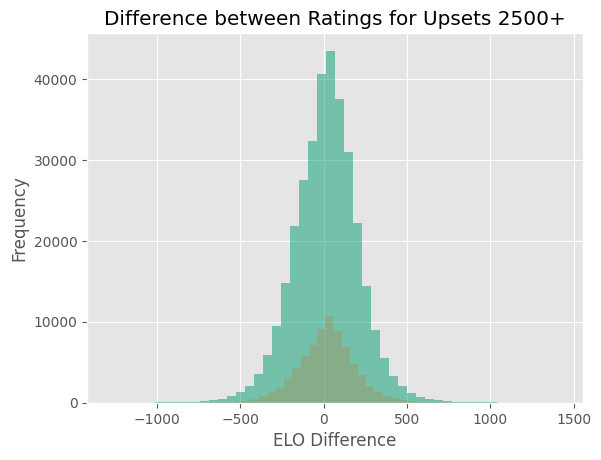

In [59]:
df_upsets= (
    df_.query("(WhiteIsRatedHigher and Result == '0-1') or (not WhiteIsRatedHigher and Result == '1-0')"
)
.reset_index(drop=True)
.copy()
)

ax= df_upsets["Elo_diff"].plot(
    kind="hist",
    bins=50,
    title="Difference between Ratings for Upsets", 
    color=pal[2],
    alpha=0.5,
)
ax=df_upsets.loc[df_upsets[["WhiteElo", "BlackElo"]].max(axis=1)>2500][
    "Elo_diff"
    ].plot(
    kind="hist",
    bins=50,
    title="Difference between Ratings for Upsets 2500+",
    color=pal[3],
    alpha=0.2,
)
ax.set_xlabel("ELO Difference")
plt.show()

ax.set_xlabel("ELO Difference")
plt.show()

In [60]:
df_upsets= (
    df_.query("(WhiteIsRatedHigher and Result == '0-1') or (not WhiteIsRatedHigher and Result == '1-0')"
)
.reset_index(drop=True)
.copy()
)


In [61]:
df_upsets["Elo_diff_abs"] = df_upsets["Elo_diff"].abs()

In [62]:
df_upsets.loc[df_upsets[["WhiteElo", "BlackElo"]].max(axis=1)>2500].query(
    "Online == False and (White == 'Nakamura,Hi' or Black == 'Nakamura,Hi')"
).sort_values("Elo_diff_abs",ascending=False).head(1)

,twic_number,White,Black,Date,EventDate,Event,Result,mainline_moves,Site,Online,Round,ECO,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo,Variation,WhiteTitle,BlackTitle,WhiteTeam,BlackTeam,EventType,FEN,SetUp,Variant,Board,PlyCount,EventCategory,Year,Week,Elo_diff,WhiteIsRatedHigher,Elo_diff_abs
56781,1093,"Pelletier,Y","Nakamura,Hi",2015-10-19,2015.10.18,31st ECC Open 2015,1-0,1. d4 Nf6 2. c4 g6 3. Nc3 Bg7 4. e4 d6 5. Nf3 ...,Skopje MKD,False,2.4,E97,King's Indian,1301837,2016192,2557,2816,"orthodox, Aronin-Taimanov, bayonet attack",GM,GM,SCHACHGESELLSCHAFT ZURICH (SUI),OBIETTIVO RISARCIMENTO PADOVA (ITA),None,None,None,None,None,None,None,2015,43,259,False,259


# Pull the PGN file from the archive

In [63]:

with open("C:/Users/hp/Downloads/archive/pgns/twic1094.pgn","r") as f:
   for _ in  range(1_000_000):
    game = chess.pgn.read_game(f)
    if(game.headers['Event'] == '31st ECC Open 2015') & (game.headers['Round'] == '2.4'):
        if game.headers["Black"] == "Nakamura,Hi":
            break

# Create a board and run through the game

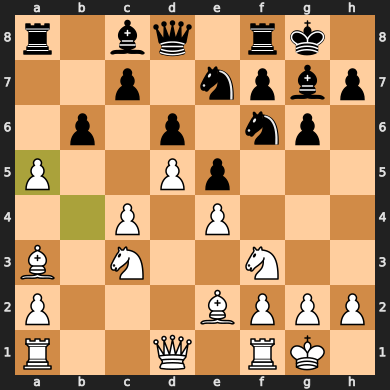

In [64]:
board = chess.Board()
for ply,move in enumerate(game.mainline_moves()):
    board.push(move)
    if ply == 20:
        break
board

# Check out Stockfish

In [65]:
import stockfish

In [66]:
from stockfish import Stockfish
stockfish_path="C:/Users/hp/Downloads/stockfish-windows-x86-64/stockfish/stockfish-windows-x86-64.exe"
stockfish = Stockfish(
    path=stockfish_path,
    depth=18,
    parameters={"Threads":32,"Minimum Thinking Time":5}
    )

# PNGs Vs FEN
-PNG  has  all the moves in the game and metadata

-FEN is the just notation for a given board setup


In [67]:
# Setup stockfish to use the current position
stockfish.set_fen_position(board.fen())

In [68]:
stockfish.get_evaluation()

{'type': 'cp', 'value': 42}

## Loop Over the Game,Evaluate each Step

In [69]:
from tqdm.notebook import tqdm

  0%|          | 0/75 [00:00<?, ?it/s]

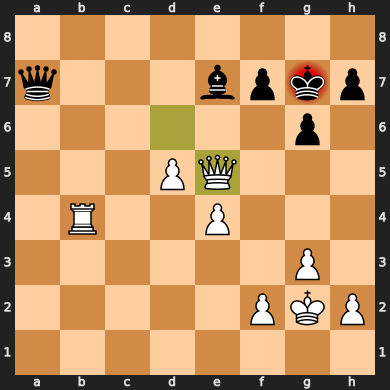

In [70]:
results = []
board = chess.Board()
ply_length = len([x for x in game.mainline_moves()])
for ply,move in tqdm(enumerate(game.mainline_moves()),total=ply_length):
    board.push(move)
    stockfish.set_fen_position(board.fen())
    evaluation = stockfish.get_evaluation()
    results.append(evaluation)
    #if ply == 20:
     #   break
board

<Axes: title={'center': 'Game Evaluation'}>

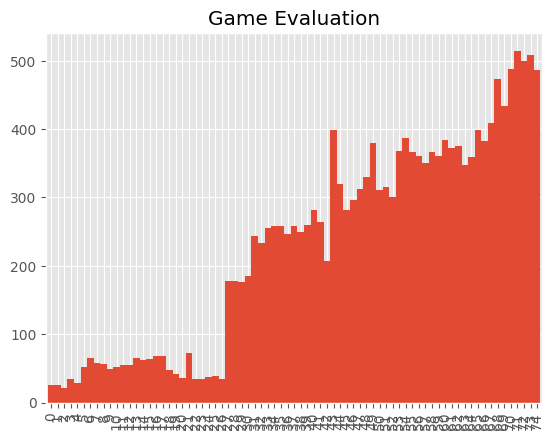

In [71]:
pd.DataFrame(results)["value"].plot(kind="bar",width=1,title="Game Evaluation")

# Run the evaluation on a different game

  0%|          | 0/126 [00:00<?, ?it/s]

<Axes: title={'center': 'Game Evaluation'}>

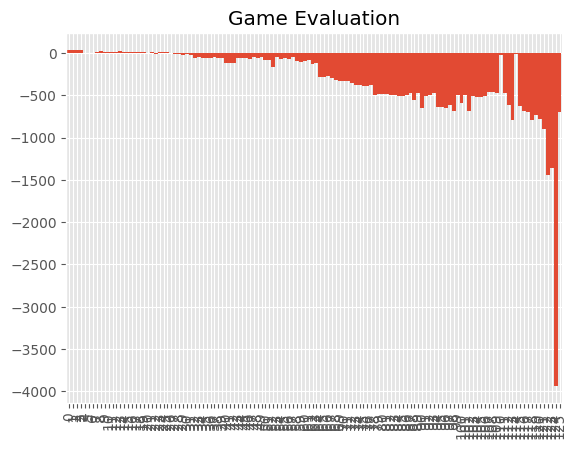

In [72]:

with open("C:/Users/hp/Downloads/archive/pgns/twic1450.pgn","r") as f:
   for _ in  range(1_000_000):
    game = chess.pgn.read_game(f)
    if(game.headers['Event'] == 'FTX Crypto Cup 2022') & (game.headers['Round'] == '7.5'):
        if game.headers["White"] == "Carlsen,M":
            break

results = []
board = chess.Board()
ply_length = len([x for x in game.mainline_moves()])
for ply,move in tqdm(enumerate(game.mainline_moves()),total=ply_length):
    board.push(move)
    stockfish.set_fen_position(board.fen())
    evaluation = stockfish.get_evaluation()
    results.append(evaluation)
    #if ply == 20:
     #   break
board

pd.DataFrame(results)["value"].plot(kind="bar",width=1,title="Game Evaluation")